<a href="https://colab.research.google.com/github/pai-cas-deads/CAS_Transferarbeit_pai/blob/main/Code_Flatfox.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mounted at /content/drive
Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Ign:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy Release [5,713 B]
Get:8 https://r2u.stat.illinois.edu/ubuntu jammy Release.gpg [793 B]
Hit:9 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Get:10 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Hit:11 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:13 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packag

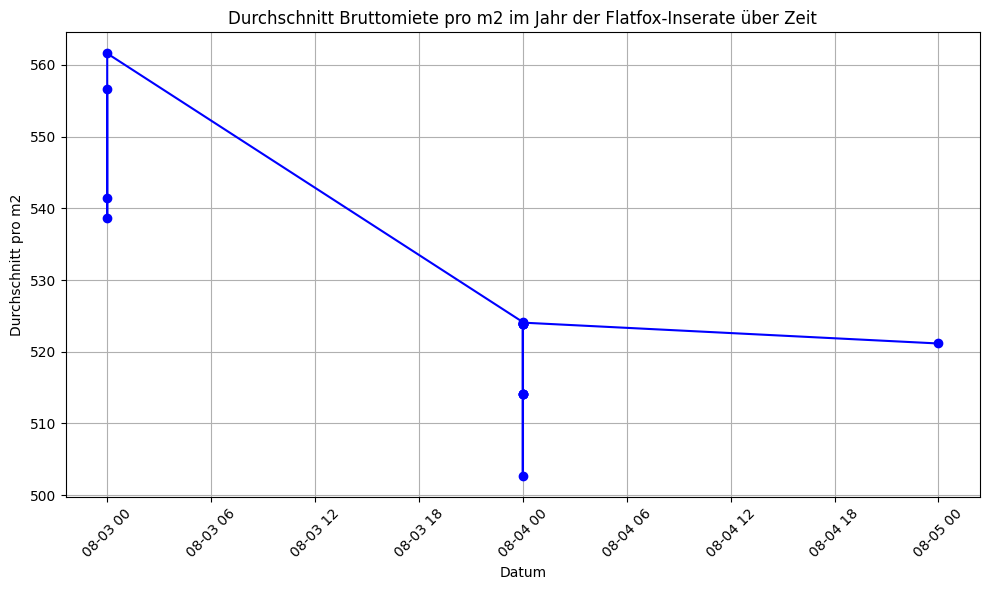

Plot abgespeichert in /content/drive/MyDrive/04-Plot/weekly_average_plot.png
Email versendet


In [ ]:
# @title Default title text
from google.colab import drive
drive.mount('/content/drive')

# Install Chrome
!apt-get update
!apt-get install -y wget unzip
!wget -q https://dl.google.com/linux/direct/google-chrome-stable_current_amd64.deb
!dpkg -i google-chrome-stable_current_amd64.deb
!apt-get -f install -y

# Check the installed version of Chrome
!google-chrome --version

# Install the latest ChromeDriver
import subprocess

# Get the latest ChromeDriver version number
result = subprocess.run(['curl', '-sS', 'chromedriver.storage.googleapis.com/LATEST_RELEASE'], stdout=subprocess.PIPE)
LATEST_VERSION = result.stdout.decode('utf-8').strip()

# Download and install ChromeDriver
subprocess.run(['wget', f'https://chromedriver.storage.googleapis.com/{LATEST_VERSION}/chromedriver_linux64.zip'])
subprocess.run(['unzip', 'chromedriver_linux64.zip'])
subprocess.run(['mv', 'chromedriver', '/usr/local/bin/chromedriver'])
subprocess.run(['chmod', '+x', '/usr/local/bin/chromedriver'])

# Install Selenium
!pip install selenium
!pip install webdriver-manager
!pip install pandas
!pip install matplotlib

# Import Packages
from selenium import webdriver
from selenium.common.exceptions import TimeoutException, NoSuchElementException, ElementClickInterceptedException
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from webdriver_manager.chrome import ChromeDriverManager
import pandas as pd
import time
import datetime
import re  # Import regular expressions module

# Import Timer
start_time = time.time()

# Pfad zu Chrome-Binary
chrome_options = Options()
chrome_options.add_argument("--headless")
chrome_options.add_argument("--no-sandbox")
chrome_options.add_argument("--disable-dev-shm-usage")
chrome_options.binary_location = "/usr/bin/google-chrome"


# Suche URLs mit Zurich
def get_zurich_urls(driver, base_url):
    urls = []
    page = 1
    max_pages = 2  # Anzahl Seiten maximal zu iterieren

    driver.get(base_url)

    while page <= max_pages:
        try:
            # Wartezeit flatfox laden
            wait = WebDriverWait(driver, 60)
            wait.until(EC.presence_of_element_located((By.CLASS_NAME, 'listing-thumb-title')))

            # Inserate auf flatfox suchen
            listings = driver.find_elements(By.CLASS_NAME, 'listing-thumb')

            if not listings:
                print(f"Keine Inserate mehr gefunden auf Seite {page}.")
                break

            # URLs aus Inseraten lesen
            for listing in listings:
                try:
                    link_element = listing.find_element(By.TAG_NAME, 'a')
                    link = link_element.get_attribute("href")
                    if link not in urls:  # Duplikate entfernen
                        urls.append(link)
                except NoSuchElementException:
                    print(f"Fehler bei der Suche der Link im Inserat auf Seite {page}.")
                    continue

            print(f"Found {len(listings)} listings on page {page}.")

            # Nächste Seite mit Inseraten durchsuchen (inkl. Zeitverzögerung zum laden)
            try:
                show_more_button = wait.until(
                    EC.element_to_be_clickable((By.XPATH, '//button[@aria-label="Mehr anzeigen"]'))
                )
                driver.execute_script("arguments[0].scrollIntoView();", show_more_button)
                driver.execute_script("arguments[0].click();", show_more_button)
                print(f"'Mehr anzeigen' Button auf Seite {page} ausgelöst.")
                time.sleep(5)  # Zeitverzögerung um Seite zu laden (sicher stellen, dass nach unten gescrollt wurde und alles geladen wurde
            except TimeoutException:
                print(f"Keine 'Mehr anzeigen' Button gefunden oder anwählbar auf Seite {page}.")
                break
            except ElementClickInterceptedException:
                print(f"Nicht möglich den 'Mehr anzeigen' Button auszulösen auf Seite {page}.")
                break

            page += 1
        except Exception as e:
            print(f"Fehler auf Seite {page}: {e}")
            break

    return urls


# Extraktion der Daten aus der URL
def extract_listing_data(driver, url):
    driver.get(url)

    # Zeit um Webpage zu laden
    wait = WebDriverWait(driver, 30)
    wait.until(EC.presence_of_element_located((By.CLASS_NAME, 'widget-listing-title')))

    # Title
    try:
        title_element = driver.find_element(By.TAG_NAME, 'h1')
        title = title_element.text.strip() if title_element else 'N/A'
    except Exception as e:
        print(f"Error finding title: {e}")
        title = 'N/A'

    # Price
    try:
        price_element = driver.find_element(By.XPATH, "//td[contains(text(), 'Bruttomiete (inkl. NK):')]/following-sibling::td")
        price = price_element.text.strip() if price_element else 'N/A'
    except Exception as e:
        print(f"Error finding price: {e}")
        price = 'N/A'

    # Size
    try:
        size_element = driver.find_element(By.XPATH, "//td[contains(text(), 'Wohnfläche:')]/following-sibling::td")
        size = size_element.text.strip() if size_element else 'N/A'
    except Exception as e:
        print(f"Error finding size: {e}")
        size = 'N/A'

    # Location
    try:
        location_element = driver.find_element(By.TAG_NAME, 'h2')
        location = location_element.text.strip() if location_element else 'N/A'
    except Exception as e:
        print(f"Error finding location: {e}")
        location = 'N/A'

    # Description
    try:
        description_element = driver.find_element(By.CLASS_NAME, 'markdown')
        description = description_element.text.strip() if description_element else 'N/A'
    except Exception as e:
        print(f"Error finding description: {e}")
        description = 'N/A'

    return {
        'Title': title,
        'Price': price,
        'Size': size,
        'Location': location,
        'Description': description,
        'Link': url
    }

# Aufsetzen: Selenium WebDriver
chrome_options = Options()
chrome_options.add_argument("--headless")
chrome_options.add_argument("--no-sandbox")
chrome_options.add_argument("--disable-dev-shm-usage")

service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=chrome_options)

try:
    # Suche URLs für Inserate in Zürich aus Data-Base
    base_url = 'https://flatfox.ch/de/search/?city=Zurich&east=8.603908&north=47.417719&object_category=APARTMENT&offer_type=RENT&south=47.356145&take=48&west=8.442074'
    zurich_urls = get_zurich_urls(driver, base_url)

    # Liste erstellen
    data = []

    # Iteration durch URLs und Daten-Extraktion
    for url in zurich_urls:
        listing_data = extract_listing_data(driver, url)
        data.append(listing_data)

    # Data-Frame
    df = pd.DataFrame(data)

    # Speichern des Raw DataFrame
    raw_output_path = "/content/drive/MyDrive/01-Raw_Output/flatfox_listings_zurich_raw.csv"
    df.to_csv(raw_output_path, index=False)

    # Zahlen der Anzahl Zimmer im Titel umwandeln, z.B. '3 1/2' to '3.5'
    def convert_to_number(text):
        if text == 'N/A':
            return text
        # Bruchzahlen (1/2) ersetzen mit 0.5
        text = text.replace('½', '.5').replace('1/2', '.5')
        # Nicht-numerische Zeichen entfernen, ausser '.'
        text = re.sub(r'[^\d.]', '', text)
        try:
            return float(text)
        except ValueError:
            return 'N/A'

    # Neue Spalte erstellen mit den bereinigten Daten
    df['No_Rooms'] = df['Title'].apply(convert_to_number)

    # Funktion umwandeln in Zahl bei Price und Size anwenden
    df['Price'] = df['Price'].apply(convert_to_number)
    df['Size'] = df['Size'].apply(convert_to_number)

    # Die Spalten Price und Size in numerische Werte umwandeln und errors='coerce' setzen, um alle verbleibenden nicht numerischen Werte zu behandeln
    df['Price'] = pd.to_numeric(df['Price'], errors='coerce')
    df['Size'] = pd.to_numeric(df['Size'], errors='coerce')

    # Zusätzliche Bereinigung: Zeilen entfernen, die "möbliert" oder "temporär" in der 'Description'-Spalte enthalten
    df_cleaned = df[(df['Location'].str.contains('Zürich')) & (df['Price'].notna()) & (df['Size'].notna())]
    df_cleaned = df_cleaned[~df_cleaned['Description'].str.contains('möbliert|temporär|befristet|untermiete|untervermiet|furnished|sublet', case=False, na=False)]

    # Spalte für average per m2 erstellen
    df_cleaned['Average_per_m2'] = (df_cleaned['Price'] / df_cleaned['Size']) * 12

    # Speichern des bereinigten DataFrame
    cleaned_output_path = "/content/drive/MyDrive/02-Cleaned_Output/flatfox_listings_zurich_cleaned.csv"
    df_cleaned.to_csv(cleaned_output_path, index=False)

    # Wöchentlicher Durchschnittspreis pro m² und Anzahl Inserate speichern
    weekly_avg = df_cleaned['Average_per_m2'].mean()
    no_inserate = df_cleaned.shape[0]  # Anzahl der Inserate
    weekly_data = pd.DataFrame({'Date': [datetime.datetime.now().strftime("%Y-%m-%d")], 'Weekly_Average_per_m2': [weekly_avg], 'No_Inserate': [no_inserate]})

    # Datei einlesen oder erstellen, um den wöchentlichen Durchschnitt zu speichern
    weekly_avg_file = "/content/drive/MyDrive/03-Weekly_avg/weekly_averages.csv"
    try:
        df_weekly = pd.read_csv(weekly_avg_file)
        df_weekly = pd.concat([df_weekly, weekly_data], ignore_index=True)
    except FileNotFoundError:
        df_weekly = weekly_data

    # Speichern des aktualisierten wöchentlichen Durchschnitts
    df_weekly.to_csv(weekly_avg_file, index=False)

    print(f"Raw data scraped und unter {raw_output_path} abgespeichert.")
    print(f"Cleaned data unter {cleaned_output_path} abgespeichert.")
    print(f"Weekly average unter {weekly_avg_file} abgespeichert.")

except Exception as e:
    print(f"Fehler: {e}")

finally:
    driver.quit()

# Zeit stoppen
end_time = time.time()
duration = end_time - start_time
print(f"Zeiaufwand web scraping: {datetime.timedelta(seconds=duration)}")


###########

import pandas as pd
import matplotlib.pyplot as plt
import smtplib
from email.mime.multipart import MIMEMultipart
from email.mime.base import MIMEBase
from email import encoders
from email.mime.text import MIMEText
from email.mime.image import MIMEImage
from email.utils import formataddr

# Datei einlesen
weekly_avg_file = "/content/drive/MyDrive/03-Weekly_avg/weekly_averages.csv"
df_weekly = pd.read_csv(weekly_avg_file)

# Sicherstellen, dass die 'Date'-Spalte als Datetime-Objekt gelesen wird
df_weekly['Date'] = pd.to_datetime(df_weekly['Date'])

# Datenüberprüfung
print(df_weekly.head())
print(df_weekly.info())

# Fehlende Werte identifizieren
print("Fehlende Werte in den Spalten:")
print(df_weekly.isna().sum())

# Fehlende Werte behandeln (Zeilen mit fehlenden Werten in 'Weekly_Average_per_m2' entfernen)
df_weekly = df_weekly.dropna(subset=['Weekly_Average_per_m2'])

# Überprüfen, ob die DataFrame nicht leer ist und keine fehlenden Werte enthält
if not df_weekly.empty and df_weekly['Date'].notna().all() and df_weekly['Weekly_Average_per_m2'].notna().all():
    # Plot erstellen
    plt.figure(figsize=(10, 6))
    plt.plot(df_weekly['Date'], df_weekly['Weekly_Average_per_m2'], marker='o', linestyle='-', color='b')
    plt.xlabel('Datum')
    plt.ylabel('Durchschnitt pro m2')
    plt.title('Durchschnitt Bruttomiete pro m2 im Jahr der Flatfox-Inserate über Zeit')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()

    # Plot speichern
    plot_output_path = "/content/drive/MyDrive/04-Plot/weekly_average_plot.png"
    plt.savefig(plot_output_path)

    # Plot anzeigen
    plt.show()

    print(f"Plot abgespeichert in {plot_output_path}")

    # E-Mail versenden
    from_email = "pai.cas.deads@gmail.com"
    to_email = "airoldi.philippe@gmail.com"
    subject = "Entwicklung Durchschnittsmieten Flatfox in Zürich"
    body = "Guten Morgen. Im Anhang findest du die täglich aktualisierte Entwicklung der Mieten auf dem Flatfox-Portal für die Stadt Zürich."

    msg = MIMEMultipart()
    msg['From'] = formataddr(('Sender Name', from_email))
    msg['To'] = to_email
    msg['Subject'] = subject

    msg.attach(MIMEText(body, 'plain'))

    with open(plot_output_path, 'rb') as attachment:
        part = MIMEBase('application', 'octet-stream')
        part.set_payload(attachment.read())
        encoders.encode_base64(part)
        part.add_header(
            'Content-Disposition',
            f'attachment; filename= {plot_output_path}',
        )
        msg.attach(part)

    try:
        with smtplib.SMTP('smtp.gmail.com', 587) as server:
            server.starttls()
            server.login(from_email, 'ptcb usaj vejj hkyf')  # Hier das Passwort des Absenderkontos einfügen
            server.sendmail(from_email, to_email, msg.as_string())
        print("Email versendet")
    except Exception as e:
        print(f"Versand an Mailadresse {e} fehlgeschlagen")
else:
    print("DataFrame ist leer oder enthält leere Werte. Keine Daten im Plot.")
